# Import library

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: 


In [2]:
import time
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

2024-10-23 16:28:37.963228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 16:28:38.129483: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 16:28:38.175459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 16:28:38.476757: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 16:28:40.370899: W tensorflow/compiler/tf2

In [3]:
# Cek apakah ada GPU yang tersedia
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"TensorFlow mendeteksi {len(gpus)} GPU:")
    for gpu in gpus:
        print(gpu)
else:
    print("TensorFlow tidak mendeteksi GPU.")

TensorFlow mendeteksi 1 GPU:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1729675725.201836   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729675725.548679   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729675725.548756   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# EfficientNet Original

## Source code 

In [11]:
import copy
import math

from keras.src import backend
from keras.src import layers
from keras.src.api_export import keras_export
from keras.src.applications import imagenet_utils
from keras.src.models import Functional
from keras.src.ops import operation_utils
from keras.src.utils import file_utils

BASE_WEIGHTS_PATH = "https://storage.googleapis.com/keras-applications/"

WEIGHTS_HASHES = {
    "b0": (
        "902e53a9f72be733fc0bcb005b3ebbac",
        "50bc09e76180e00e4465e1a485ddc09d",
    ),
    "b1": (
        "1d254153d4ab51201f1646940f018540",
        "74c4e6b3e1f6a1eea24c589628592432",
    ),
    "b2": (
        "b15cce36ff4dcbd00b6dd88e7857a6ad",
        "111f8e2ac8aa800a7a99e3239f7bfb39",
    ),
    "b3": (
        "ffd1fdc53d0ce67064dc6a9c7960ede0",
        "af6d107764bb5b1abb91932881670226",
    ),
    "b4": (
        "18c95ad55216b8f92d7e70b3a046e2fc",
        "ebc24e6d6c33eaebbd558eafbeedf1ba",
    ),
    "b5": (
        "ace28f2a6363774853a83a0b21b9421a",
        "38879255a25d3c92d5e44e04ae6cec6f",
    ),
    "b6": (
        "165f6e37dce68623721b423839de8be5",
        "9ecce42647a20130c1f39a5d4cb75743",
    ),
    "b7": (
        "8c03f828fec3ef71311cd463b6759d99",
        "cbcfe4450ddf6f3ad90b1b398090fe4a",
    ),
}

DEFAULT_BLOCKS_ARGS = [
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 32,
        "filters_out": 16,
        "expand_ratio": 1,
        "id_skip": True,
        "strides": 1,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 3,
        "repeats": 2,
        "filters_in": 16,
        "filters_out": 24,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 5,
        "repeats": 2,
        "filters_in": 24,
        "filters_out": 40,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 3,
        "repeats": 3,
        "filters_in": 40,
        "filters_out": 80,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 5,
        "repeats": 3,
        "filters_in": 80,
        "filters_out": 112,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 1,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 5,
        "repeats": 4,
        "filters_in": 112,
        "filters_out": 192,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 192,
        "filters_out": 320,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 1,
        "se_ratio": 0.25,
    },
]

CONV_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {
        "scale": 2.0,
        "mode": "fan_out",
        "distribution": "truncated_normal",
    },
}

DENSE_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {
        "scale": 1.0 / 3.0,
        "mode": "fan_out",
        "distribution": "uniform",
    },
}

BASE_DOCSTRING = """Instantiates the {name} architecture.

Reference:
- [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](
    https://arxiv.org/abs/1905.11946) (ICML 2019)

This function returns a Keras image classification model,
optionally loaded with weights pre-trained on ImageNet.

For image classification use cases, see
[this page for detailed examples](
https://keras.io/api/applications/#usage-examples-for-image-classification-models).

For transfer learning use cases, make sure to read the
[guide to transfer learning & fine-tuning](
https://keras.io/guides/transfer_learning/).

Note: each Keras Application expects a specific kind of input preprocessing.
For EfficientNet, input preprocessing is included as part of the model
(as a `Rescaling` layer), and thus
`keras.applications.efficientnet.preprocess_input` is actually a
pass-through function. EfficientNet models expect their inputs to be float
tensors of pixels with values in the `[0-255]` range.

Args:
    include_top: Whether to include the fully-connected
        layer at the top of the network. Defaults to `True`.
    weights: One of `None` (random initialization),
        `"imagenet"` (pre-training on ImageNet),
        or the path to the weights file to be loaded.
        Defaults to `"imagenet"`.
    input_tensor: Optional Keras tensor
        (i.e. output of `layers.Input()`)
        to use as image input for the model.
    input_shape: Optional shape tuple, only to be specified
        if `include_top` is False.
        It should have exactly 3 inputs channels.
    pooling: Optional pooling mode for feature extraction
        when `include_top` is `False`. Defaults to `None`.
        - `None` means that the output of the model will be
            the 4D tensor output of the
            last convolutional layer.
        - `avg` means that global average pooling
            will be applied to the output of the
            last convolutional layer, and thus
            the output of the model will be a 2D tensor.
        - `max` means that global max pooling will
            be applied.
    classes: Optional number of classes to classify images
        into, only to be specified if `include_top` is True, and
        if no `weights` argument is specified. 1000 is how many
        ImageNet classes there are. Defaults to `1000`.
    classifier_activation: A `str` or callable. The activation function to use
        on the "top" layer. Ignored unless `include_top=True`. Set
        `classifier_activation=None` to return the logits of the "top" layer.
        Defaults to `'softmax'`.
        When loading pretrained weights, `classifier_activation` can only
        be `None` or `"softmax"`.

Returns:
    A model instance.
"""


IMAGENET_STDDEV_RGB = [0.229, 0.224, 0.225]


def EfficientNet(
    width_coefficient,
    depth_coefficient,
    default_size,
    dropout_rate=0.2,
    drop_connect_rate=0.2,
    depth_divisor=8,
    activation="swish",
    blocks_args="default",
    model_name="efficientnet",
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    """Instantiates the EfficientNet architecture.

    Args:
      width_coefficient: float, scaling coefficient for network width.
      depth_coefficient: float, scaling coefficient for network depth.
      default_size: integer, default input image size.
      dropout_rate: float, dropout rate before final classifier layer.
      drop_connect_rate: float, dropout rate at skip connections.
      depth_divisor: integer, a unit of network width.
      activation: activation function.
      blocks_args: list of dicts, parameters to construct block modules.
      model_name: string, model name.
      include_top: whether to include the fully-connected
          layer at the top of the network.
      weights: one of `None` (random initialization),
            'imagenet' (pre-training on ImageNet),
            or the path to the weights file to be loaded.
      input_tensor: optional Keras tensor
          (i.e. output of `layers.Input()`)
          to use as image input for the model.
      input_shape: optional shape tuple, only to be specified
          if `include_top` is False.
          It should have exactly 3 inputs channels.
      pooling: optional pooling mode for feature extraction
          when `include_top` is `False`.
          - `None` means that the output of the model will be
              the 4D tensor output of the
              last convolutional layer.
          - `avg` means that global average pooling
              will be applied to the output of the
              last convolutional layer, and thus
              the output of the model will be a 2D tensor.
          - `max` means that global max pooling will
              be applied.
      classes: optional number of classes to classify images
          into, only to be specified if `include_top` is True, and
          if no `weights` argument is specified.
      classifier_activation: A `str` or callable. The activation function to use
          on the "top" layer. Ignored unless `include_top=True`. Set
          `classifier_activation=None` to return the logits of the "top" layer.

    Returns:
        A model instance.
    """
    if blocks_args == "default":
        blocks_args = DEFAULT_BLOCKS_ARGS

    if not (weights in {"imagenet", None} or file_utils.exists(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), `imagenet` "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded."
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            'If using `weights="imagenet"` with `include_top`'
            " as true, `classes` should be 1000"
        )

    # Determine proper input shape
    input_shape = imagenet_utils.obtain_input_shape(
        input_shape,
        default_size=default_size,
        min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights,
    )

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    def round_filters(filters, divisor=depth_divisor):
        """Round number of filters based on depth multiplier."""
        filters *= width_coefficient
        new_filters = max(
            divisor, int(filters + divisor / 2) // divisor * divisor
        )
        # Make sure that round down does not go down by more than 10%.
        if new_filters < 0.9 * filters:
            new_filters += divisor
        return int(new_filters)

    def round_repeats(repeats):
        """Round number of repeats based on depth multiplier."""
        return int(math.ceil(depth_coefficient * repeats))

    # Build stem
    x = img_input
    x = layers.Rescaling(1.0 / 255.0)(x)
    x = layers.Normalization(axis=bn_axis)(x)
    if weights == "imagenet":
        # Note that the normaliztion layer uses square value of STDDEV as the
        # variance for the layer: result = (input - mean) / sqrt(var)
        # However, the original implemenetation uses (input - mean) / var to
        # normalize the input, we need to divide another sqrt(var) to match the
        # original implementation.
        # See https://github.com/tensorflow/tensorflow/issues/49930 for more
        # details
        x = layers.Rescaling(
            [1.0 / math.sqrt(stddev) for stddev in IMAGENET_STDDEV_RGB]
        )(x)

    x = layers.ZeroPadding2D(
        padding=imagenet_utils.correct_pad(x, 3), name="stem_conv_pad"
    )(x)
    x = layers.Conv2D(
        round_filters(32),
        3,
        strides=2,
        padding="valid",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name="stem_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name="stem_bn")(x)
    x = layers.Activation(activation, name="stem_activation")(x)

    # Build blocks
    blocks_args = copy.deepcopy(blocks_args)

    b = 0
    blocks = float(sum(round_repeats(args["repeats"]) for args in blocks_args))
    for i, args in enumerate(blocks_args):
        assert args["repeats"] > 0
        # Update block input and output filters based on depth multiplier.
        args["filters_in"] = round_filters(args["filters_in"])
        args["filters_out"] = round_filters(args["filters_out"])

        for j in range(round_repeats(args.pop("repeats"))):
            # The first block needs to take care of stride and filter size
            # increase.
            if j > 0:
                args["strides"] = 1
                args["filters_in"] = args["filters_out"]
            x = block(
                x,
                activation,
                drop_connect_rate * b / blocks,
                name=f"block{i + 1}{chr(j + 97)}_",
                **args,
            )
            b += 1

    # Build top
    x = layers.Conv2D(
        round_filters(1280),
        1,
        padding="same",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name="top_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name="top_bn")(x)
    x = layers.Activation(activation, name="top_activation")(x)
    if include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, name="top_dropout")(x)
        imagenet_utils.validate_activation(classifier_activation, weights)
        x = layers.Dense(
            classes,
            activation=classifier_activation,
            kernel_initializer=DENSE_KERNEL_INITIALIZER,
            name="predictions",
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D(name="max_pool")(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = operation_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = Functional(inputs, x, name=model_name)

    # Load weights.
    if weights == "imagenet":
        if include_top:
            file_suffix = ".h5"
            file_hash = WEIGHTS_HASHES[model_name[-2:]][0]
        else:
            file_suffix = "_notop.h5"
            file_hash = WEIGHTS_HASHES[model_name[-2:]][1]
        file_name = model_name + file_suffix
        weights_path = file_utils.get_file(
            file_name,
            BASE_WEIGHTS_PATH + file_name,
            cache_subdir="models",
            file_hash=file_hash,
        )
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)
    return model


def block(
    inputs,
    activation="swish",
    drop_rate=0.0,
    name="",
    filters_in=32,
    filters_out=16,
    kernel_size=3,
    strides=1,
    expand_ratio=1,
    se_ratio=0.0,
    id_skip=True,
):
    """An inverted residual block.

    Args:
        inputs: input tensor.
        activation: activation function.
        drop_rate: float between 0 and 1, fraction of the input units to drop.
        name: string, block label.
        filters_in: integer, the number of input filters.
        filters_out: integer, the number of output filters.
        kernel_size: integer, the dimension of the convolution window.
        strides: integer, the stride of the convolution.
        expand_ratio: integer, scaling coefficient for the input filters.
        se_ratio: float between 0 and 1, fraction to squeeze the input filters.
        id_skip: boolean.

    Returns:
        output tensor for the block.
    """
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    # Expansion phase
    filters = filters_in * expand_ratio
    if expand_ratio != 1:
        x = layers.Conv2D(
            filters,
            1,
            padding="same",
            use_bias=False,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            name=name + "expand_conv",
        )(inputs)
        x = layers.BatchNormalization(axis=bn_axis, name=name + "expand_bn")(x)
        x = layers.Activation(activation, name=name + "expand_activation")(x)
    else:
        x = inputs

    # Depthwise Convolution
    if strides == 2:
        x = layers.ZeroPadding2D(
            padding=imagenet_utils.correct_pad(x, kernel_size),
            name=name + "dwconv_pad",
        )(x)
        conv_pad = "valid"
    else:
        conv_pad = "same"
    x = layers.DepthwiseConv2D(
        kernel_size,
        strides=strides,
        padding=conv_pad,
        use_bias=False,
        depthwise_initializer=CONV_KERNEL_INITIALIZER,
        name=name + "dwconv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + "bn")(x)
    x = layers.Activation(activation, name=name + "activation")(x)

    # Squeeze and Excitation phase
    if 0 < se_ratio <= 1:
        filters_se = max(1, int(filters_in * se_ratio))
        se = layers.GlobalAveragePooling2D(name=name + "se_squeeze")(x)
        if bn_axis == 1:
            se_shape = (filters, 1, 1)
        else:
            se_shape = (1, 1, filters)
        se = layers.Reshape(se_shape, name=name + "se_reshape")(se)
        se = layers.Conv2D(
            filters_se,
            1,
            padding="same",
            activation=activation,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            name=name + "se_reduce",
        )(se)
        se = layers.Conv2D(
            filters,
            1,
            padding="same",
            activation="sigmoid",
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            name=name + "se_expand",
        )(se)
        x = layers.multiply([x, se], name=name + "se_excite")

    # Output phase
    x = layers.Conv2D(
        filters_out,
        1,
        padding="same",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name=name + "project_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + "project_bn")(x)
    if id_skip and strides == 1 and filters_in == filters_out:
        if drop_rate > 0:
            x = layers.Dropout(
                drop_rate, noise_shape=(None, 1, 1, 1), name=name + "drop"
            )(x)
        x = layers.add([x, inputs], name=name + "add")
    return x


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB0",
        "keras.applications.EfficientNetB0",
    ]
)
def EfficientNetB0(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.0,
        1.0,
        224,
        0.2,
        model_name="efficientnetb0",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB1",
        "keras.applications.EfficientNetB1",
    ]
)
def EfficientNetB1(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.0,
        1.1,
        240,
        0.2,
        model_name="efficientnetb1",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB2",
        "keras.applications.EfficientNetB2",
    ]
)
def EfficientNetB2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.1,
        1.2,
        260,
        0.3,
        model_name="efficientnetb2",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB3",
        "keras.applications.EfficientNetB3",
    ]
)
def EfficientNetB3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.2,
        1.4,
        300,
        0.3,
        model_name="efficientnetb3",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB4",
        "keras.applications.EfficientNetB4",
    ]
)
def EfficientNetB4(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.4,
        1.8,
        380,
        0.4,
        model_name="efficientnetb4",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB5",
        "keras.applications.EfficientNetB5",
    ]
)
def EfficientNetB5(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.6,
        2.2,
        456,
        0.4,
        model_name="efficientnetb5",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB6",
        "keras.applications.EfficientNetB6",
    ]
)
def EfficientNetB6(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.8,
        2.6,
        528,
        0.5,
        model_name="efficientnetb6",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB7",
        "keras.applications.EfficientNetB7",
    ]
)
def EfficientNetB7(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        2.0,
        3.1,
        600,
        0.5,
        model_name="efficientnetb7",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


EfficientNetB0.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB0")
EfficientNetB1.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB1")
EfficientNetB2.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB2")
EfficientNetB3.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB3")
EfficientNetB4.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB4")
EfficientNetB5.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB5")
EfficientNetB6.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB6")
EfficientNetB7.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB7")


@keras_export("keras.applications.efficientnet.preprocess_input")
def preprocess_input(x, data_format=None):
    """A placeholder method for backward compatibility.

    The preprocessing logic has been included in the efficientnet model
    implementation. Users are no longer required to call this method to
    normalize the input data. This method does nothing and only kept as a
    placeholder to align the API surface between old and new version of model.

    Args:
        x: A floating point `numpy.array` or a tensor.
        data_format: Optional data format of the image tensor/array. `None`
            means the global setting `keras.backend.image_data_format()`
            is used (unless you changed it, it uses `"channels_last"`).
            Defaults to `None`.

    Returns:
        Unchanged `numpy.array` or tensor.
    """
    return x


@keras_export("keras.applications.efficientnet.decode_predictions")
def decode_predictions(preds, top=5):
    return imagenet_utils.decode_predictions(preds, top=top)


decode_predictions.__doc__ = imagenet_utils.decode_predictions.__doc__

## Define Function

In [12]:
def augment_and_resize_dataset(base_path, img_size, batch_size, preprocess_input_func=None):
    train_path = os.path.join(base_path, 'train')
    validation_path = os.path.join(base_path, 'val')
    test_path = os.path.join(base_path, 'test')

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_func,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Untuk data validation dan test, hanya preprocessing
    validation_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_func)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = validation_test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = validation_test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [13]:
# Fungsi untuk melatih model dan menampilkan grafik serta menyimpannya
def train_and_plot(model, model_name, train_generator, validation_generator, test_generator, epochs):
    # Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Menghitung waktu mulai pelatihan
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[early_stopping_callback]
    )
    
    # Menghitung waktu selesai pelatihan
    end_time = time.time()
    
    # Menghitung durasi pelatihan
    training_duration = end_time - start_time  # dalam detik

    # Plotting hasil akurasi
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Tampilkan plot
    plt.show()

    # Evaluasi model pada data test
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Prediksi pada data test
    y_pred = model.predict(test_generator)

    # Mengambil index dari prediksi (kelas dengan probabilitas tertinggi)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Mengambil label sebenarnya dari generator
    y_true = test_generator.classes

    # Membuat confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    class_names = list(test_generator.class_indices.keys())

    # Menampilkan classification report
    print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

    # Plot confusion matrix sebagai heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Tampilkan confusion matrix
    plt.show()

    return history, test_loss, test_accuracy, training_duration


## Training menggunakan EfficientNet Not Modified Not Trainable Weights imagenet

In [14]:
model = EfficientNetB7(input_shape=(600, 600, 3), include_top=False, weights="imagenet")
model.trainable = False

inputs = Input(shape=(600, 600, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 600, 600, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,798,362 (247.19 MB)

 Trainable params: 694,787 (2.65 MB)

 Non-trainable params: 64,103,575 (244.54 MB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1729296804.663193    2459 service.cc:146] XLA service 0x73a2c8002d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729296804.663244    2459 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-10-19 00:13:25.828978: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-19 00:13:29.722473: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8905
E0000 00:00:1729296815.989436    2459 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729296816.137867    2459 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


37/87 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.3980 - loss: 1.4651

E0000 00:00:1729296916.262986    2459 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729296916.355010    2459 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729296917.032775    2459 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729296917.118602    2459 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4090 - loss: 1.4318

E0000 00:00:1729297012.845154    2457 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729297012.952059    2457 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729297013.768475    2457 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729297013.857583    2457 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729297014.552764    2457 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

87/87 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.4093 - loss: 1.4312 - val_accuracy: 0.4368 - val_loss: 1.0524
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.4619 - loss: 1.2883 - val_accuracy: 0.5115 - val_loss: 0.9813
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5486 - loss: 1.0881 - val_accuracy: 0.5833 - val_loss: 0.8789
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.5941 - loss: 0.9940 - val_accuracy: 0.6695 - val_loss: 0.7484
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.6635 - loss: 0.8073 - val_accuracy: 0.7356 - val_loss: 0.6515
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6595 - loss: 0.8472 - val_accuracy: 0.7615 - val_loss: 0.5755
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.6628 - loss: 0.8167 - val_accuracy: 0.7787 - val_loss: 0.5390
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.7099 - loss: 0.7401 - val_accuracy: 0.7931 - val_loss: 0.5050

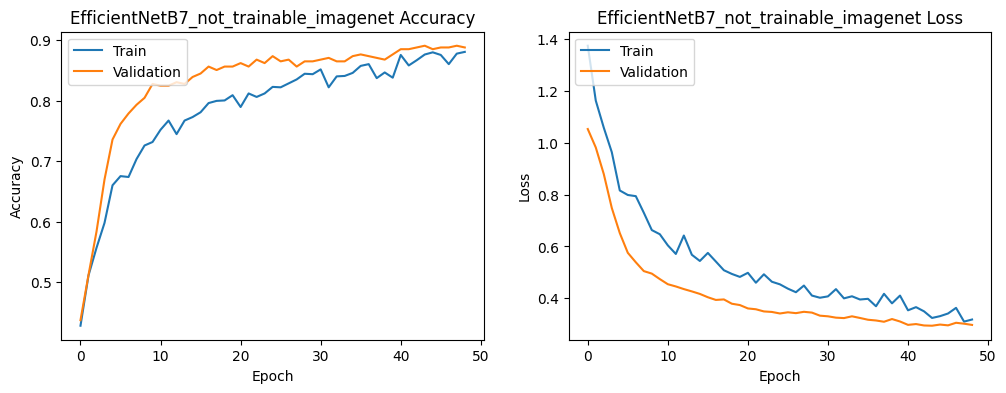

160/160 ━━━━━━━━━━━━━━━━━━━━ 35s 216ms/step - accuracy: 0.8794 - loss: 0.5863
Test Accuracy: 0.7365
160/160 ━━━━━━━━━━━━━━━━━━━━ 54s 241ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.81      0.93      0.87      1645
        rust       0.00      0.00      0.00       275
        scab       0.52      0.54      0.53       630

    accuracy                           0.74      2550
   macro avg       0.44      0.49      0.47      2550
weighted avg       0.65      0.74      0.69      2550



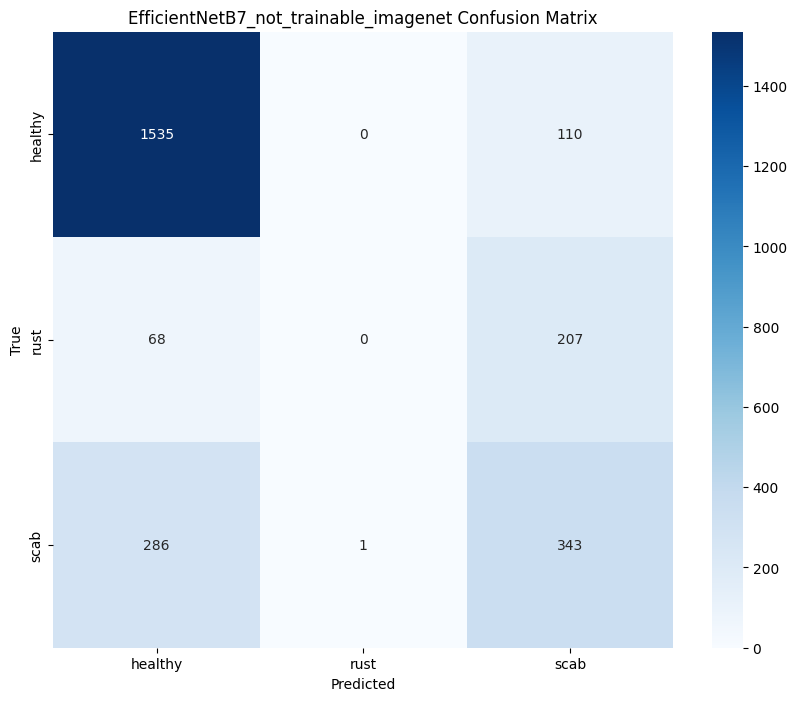

In [15]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(600, 600),
    batch_size=16,
    preprocess_input_func = efficientnet_preprocess
)

history_EN_B7_not_trainable_imagenet, test_loss, test_acc, training_duration = train_and_plot(model, "EfficientNetB7_not_trainable_imagenet", train_generator, validation_generator, test_generator, 50)

## Training menggunakan EfficientNet Not Modified Weights imagenet

In [16]:
model = EfficientNetB7(input_shape=(600, 600, 3), include_top=False, weights="imagenet")
model.trainable = True

# Freeze 50% layer pertama dari base model
total_layers = len(model.layers)
freeze_layers = int(0.50 * total_layers)
for layer in model.layers[:freeze_layers]:
    layer.trainable = False

inputs = Input(shape=(600, 600, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 600, 600, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,798,362 (247.19 MB)

 Trainable params: 59,931,739 (228.62 MB)

 Non-trainable params: 4,866,623 (18.56 MB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1729302099.811152    2458 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729302099.918272    2458 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729302100.471968    2458 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729302100.565649    2458 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729302100.971903    2458 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

36/87 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3452 - loss: 1.7117   

E0000 00:00:1729302223.578349    2462 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729302223.699798    2462 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729302224.200487    2462 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729302224.305126    2462 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729302224.724949    2462 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

87/87 ━━━━━━━━━━━━━━━━━━━━ 356s 3s/step - accuracy: 0.3809 - loss: 1.5876 - val_accuracy: 0.4397 - val_loss: 1.1683
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.5659 - loss: 0.9645 - val_accuracy: 0.5546 - val_loss: 1.0486
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.7034 - loss: 0.7612 - val_accuracy: 0.7414 - val_loss: 0.7098
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.7867 - loss: 0.5226 - val_accuracy: 0.8420 - val_loss: 0.4443
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8216 - loss: 0.4569 - val_accuracy: 0.8937 - val_loss: 0.2990
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.8770 - loss: 0.3631 - val_accuracy: 0.9224 - val_loss: 0.2228
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8704 - loss: 0.3638 - val_accuracy: 0.9368 - val_loss: 0.1843
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9115 - loss: 0.2566 - val_accuracy: 0.9339 - val_loss: 0.154

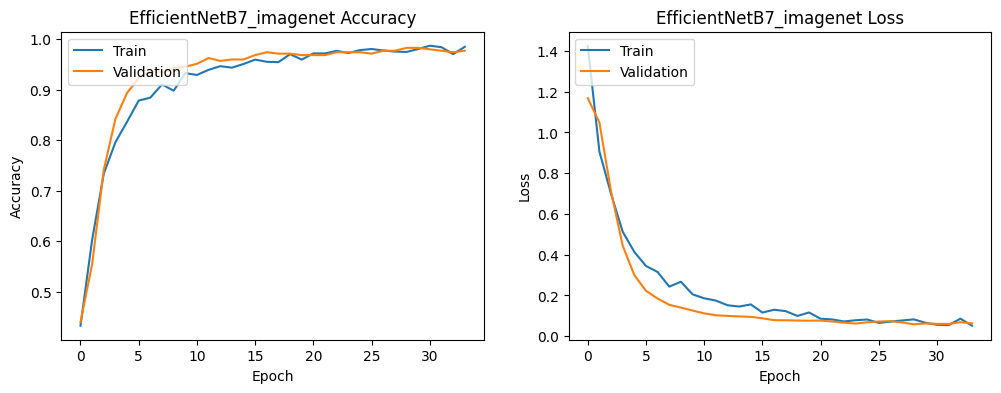

160/160 ━━━━━━━━━━━━━━━━━━━━ 34s 214ms/step - accuracy: 0.8273 - loss: 0.4829
Test Accuracy: 0.7416
160/160 ━━━━━━━━━━━━━━━━━━━━ 52s 238ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.88      0.86      0.87      1645
        rust       0.88      0.16      0.28       275
        scab       0.48      0.70      0.57       630

    accuracy                           0.74      2550
   macro avg       0.75      0.57      0.57      2550
weighted avg       0.78      0.74      0.73      2550



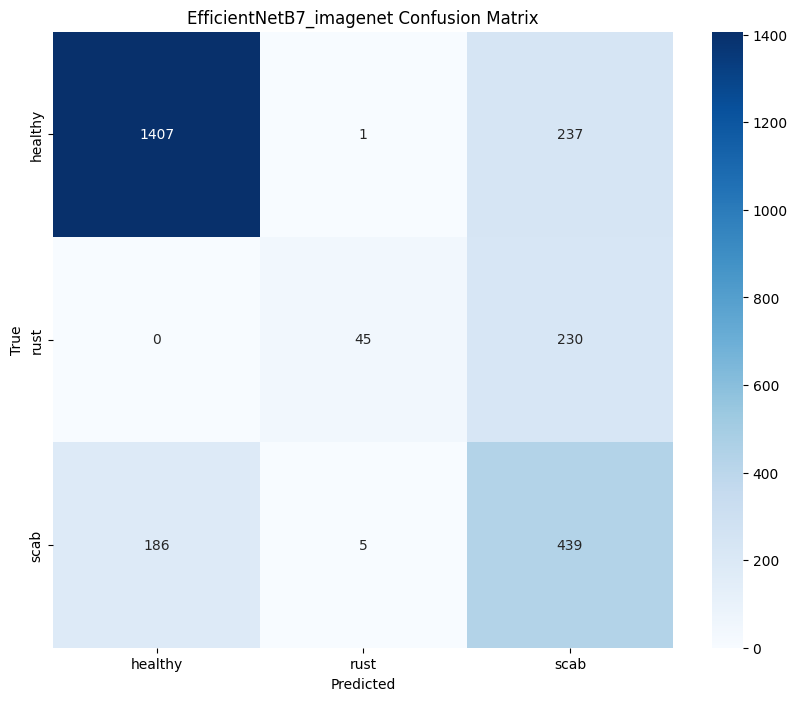

In [17]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(600, 600),
    batch_size=16,
    preprocess_input_func = efficientnet_preprocess
)

history_EN_B7_imagenet, test_loss, test_acc, training_duration = train_and_plot(model, "EfficientNetB7_imagenet", train_generator, validation_generator, test_generator, 50)

## Training menggunakan EfficientNet Not Modified Weights None

In [18]:
model = EfficientNetB0(input_shape=(600, 600, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(600, 600, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 600, 600, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 19, 19, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417,446 (16.85 MB)

 Trainable params: 4,372,095 (16.68 MB)

 Non-trainable params: 45,351 (177.16 KB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1729305897.944579    2458 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729305898.119610    2458 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729305899.585102    2458 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729305899.665677    2458 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729305900.005246    2458 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

70/87 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3768 - loss: 1.5580

E0000 00:00:1729306044.183803    2456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729306044.267347    2456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729306046.531478    2456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729306046.611029    2456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729306046.808422    2456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3760 - loss: 1.5450

E0000 00:00:1729306109.764711    2456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729306109.844892    2456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729306110.127327    2456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729306110.211106    2456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


87/87 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.3759 - loss: 1.5443 - val_accuracy: 0.3420 - val_loss: 1.1380
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.4068 - loss: 1.3330 - val_accuracy: 0.3420 - val_loss: 1.1736
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.4103 - loss: 1.3542 - val_accuracy: 0.3420 - val_loss: 1.1887
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.4023 - loss: 1.3388 - val_accuracy: 0.3420 - val_loss: 1.3265
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.3844 - loss: 1.3631 - val_accuracy: 0.3448 - val_loss: 1.2086
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.3941 - loss: 1.3729 - val_accuracy: 0.3736 - val_loss: 1.1929


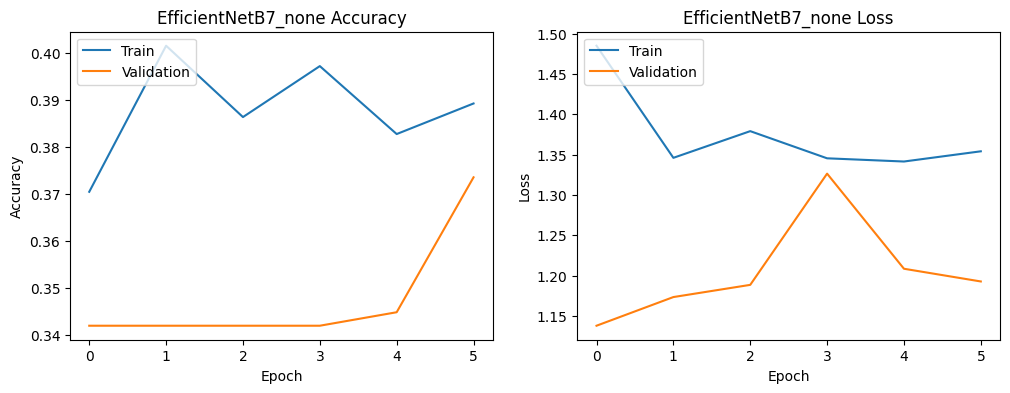

160/160 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - accuracy: 0.0363 - loss: 1.0181
Test Accuracy: 0.2471
160/160 ━━━━━━━━━━━━━━━━━━━━ 34s 179ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.00      0.00      0.00      1645
        rust       0.00      0.00      0.00       275
        scab       0.25      1.00      0.40       630

    accuracy                           0.25      2550
   macro avg       0.08      0.33      0.13      2550
weighted avg       0.06      0.25      0.10      2550



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


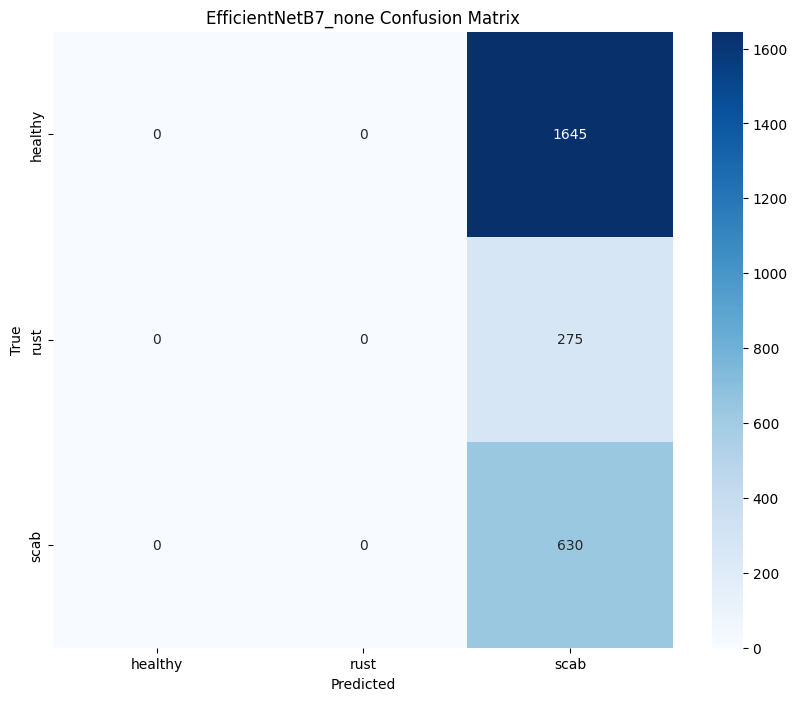

In [19]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(600, 600),
    batch_size=16,
    preprocess_input_func = efficientnet_preprocess
)

history_EN_B7_none, test_loss, test_acc, training_duration = train_and_plot(model, "EfficientNetB7_none", train_generator, validation_generator, test_generator, 50)

# EfficientNet Modified

## Source Code

In [4]:
import copy
import math

from keras.src import backend
from keras.src import layers
from keras.src.api_export import keras_export
from keras.src.applications import imagenet_utils
from keras.src.models import Functional
from keras.src.ops import operation_utils
from keras.src.utils import file_utils

BASE_WEIGHTS_PATH = "https://storage.googleapis.com/keras-applications/"

WEIGHTS_HASHES = {
    "b0": (
        "902e53a9f72be733fc0bcb005b3ebbac",
        "50bc09e76180e00e4465e1a485ddc09d",
    ),
    "b1": (
        "1d254153d4ab51201f1646940f018540",
        "74c4e6b3e1f6a1eea24c589628592432",
    ),
    "b2": (
        "b15cce36ff4dcbd00b6dd88e7857a6ad",
        "111f8e2ac8aa800a7a99e3239f7bfb39",
    ),
    "b3": (
        "ffd1fdc53d0ce67064dc6a9c7960ede0",
        "af6d107764bb5b1abb91932881670226",
    ),
    "b4": (
        "18c95ad55216b8f92d7e70b3a046e2fc",
        "ebc24e6d6c33eaebbd558eafbeedf1ba",
    ),
    "b5": (
        "ace28f2a6363774853a83a0b21b9421a",
        "38879255a25d3c92d5e44e04ae6cec6f",
    ),
    "b6": (
        "165f6e37dce68623721b423839de8be5",
        "9ecce42647a20130c1f39a5d4cb75743",
    ),
    "b7": (
        "8c03f828fec3ef71311cd463b6759d99",
        "cbcfe4450ddf6f3ad90b1b398090fe4a",
    ),
}

DEFAULT_BLOCKS_ARGS = [
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 32,
        "filters_out": 16,
        "expand_ratio": 1,
        "id_skip": True,
        "strides": 1,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 3,
        "repeats": 2,
        "filters_in": 16,
        "filters_out": 24,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 5,
        "repeats": 2,
        "filters_in": 24,
        "filters_out": 40,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    {
        "kernel_size": 3,
        "repeats": 3,
        "filters_in": 40,
        "filters_out": 80,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
        "se_ratio": 0.25,
    },
    # {
    #     "kernel_size": 5,
    #     "repeats": 3,
    #     "filters_in": 80,
    #     "filters_out": 112,
    #     "expand_ratio": 6,
    #     "id_skip": True,
    #     "strides": 1,
    #     "se_ratio": 0.25,
    # },
    # {
    #     "kernel_size": 5,
    #     "repeats": 4,
    #     "filters_in": 112,
    #     "filters_out": 192,
    #     "expand_ratio": 6,
    #     "id_skip": True,
    #     "strides": 2,
    #     "se_ratio": 0.25,
    # },
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 192,
        "filters_out": 320,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 1,
        "se_ratio": 0.25,
    },
]

CONV_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {
        "scale": 2.0,
        "mode": "fan_out",
        "distribution": "truncated_normal",
    },
}

DENSE_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {
        "scale": 1.0 / 3.0,
        "mode": "fan_out",
        "distribution": "uniform",
    },
}

BASE_DOCSTRING = """Instantiates the {name} architecture.

Reference:
- [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](
    https://arxiv.org/abs/1905.11946) (ICML 2019)

This function returns a Keras image classification model,
optionally loaded with weights pre-trained on ImageNet.

For image classification use cases, see
[this page for detailed examples](
https://keras.io/api/applications/#usage-examples-for-image-classification-models).

For transfer learning use cases, make sure to read the
[guide to transfer learning & fine-tuning](
https://keras.io/guides/transfer_learning/).

Note: each Keras Application expects a specific kind of input preprocessing.
For EfficientNet, input preprocessing is included as part of the model
(as a `Rescaling` layer), and thus
`keras.applications.efficientnet.preprocess_input` is actually a
pass-through function. EfficientNet models expect their inputs to be float
tensors of pixels with values in the `[0-255]` range.

Args:
    include_top: Whether to include the fully-connected
        layer at the top of the network. Defaults to `True`.
    weights: One of `None` (random initialization),
        `"imagenet"` (pre-training on ImageNet),
        or the path to the weights file to be loaded.
        Defaults to `"imagenet"`.
    input_tensor: Optional Keras tensor
        (i.e. output of `layers.Input()`)
        to use as image input for the model.
    input_shape: Optional shape tuple, only to be specified
        if `include_top` is False.
        It should have exactly 3 inputs channels.
    pooling: Optional pooling mode for feature extraction
        when `include_top` is `False`. Defaults to `None`.
        - `None` means that the output of the model will be
            the 4D tensor output of the
            last convolutional layer.
        - `avg` means that global average pooling
            will be applied to the output of the
            last convolutional layer, and thus
            the output of the model will be a 2D tensor.
        - `max` means that global max pooling will
            be applied.
    classes: Optional number of classes to classify images
        into, only to be specified if `include_top` is True, and
        if no `weights` argument is specified. 1000 is how many
        ImageNet classes there are. Defaults to `1000`.
    classifier_activation: A `str` or callable. The activation function to use
        on the "top" layer. Ignored unless `include_top=True`. Set
        `classifier_activation=None` to return the logits of the "top" layer.
        Defaults to `'softmax'`.
        When loading pretrained weights, `classifier_activation` can only
        be `None` or `"softmax"`.

Returns:
    A model instance.
"""


IMAGENET_STDDEV_RGB = [0.229, 0.224, 0.225]


def EfficientNet(
    width_coefficient,
    depth_coefficient,
    default_size,
    dropout_rate=0.2,
    drop_connect_rate=0.2,
    depth_divisor=8,
    activation="swish",
    blocks_args="default",
    model_name="efficientnet",
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    """Instantiates the EfficientNet architecture.

    Args:
      width_coefficient: float, scaling coefficient for network width.
      depth_coefficient: float, scaling coefficient for network depth.
      default_size: integer, default input image size.
      dropout_rate: float, dropout rate before final classifier layer.
      drop_connect_rate: float, dropout rate at skip connections.
      depth_divisor: integer, a unit of network width.
      activation: activation function.
      blocks_args: list of dicts, parameters to construct block modules.
      model_name: string, model name.
      include_top: whether to include the fully-connected
          layer at the top of the network.
      weights: one of `None` (random initialization),
            'imagenet' (pre-training on ImageNet),
            or the path to the weights file to be loaded.
      input_tensor: optional Keras tensor
          (i.e. output of `layers.Input()`)
          to use as image input for the model.
      input_shape: optional shape tuple, only to be specified
          if `include_top` is False.
          It should have exactly 3 inputs channels.
      pooling: optional pooling mode for feature extraction
          when `include_top` is `False`.
          - `None` means that the output of the model will be
              the 4D tensor output of the
              last convolutional layer.
          - `avg` means that global average pooling
              will be applied to the output of the
              last convolutional layer, and thus
              the output of the model will be a 2D tensor.
          - `max` means that global max pooling will
              be applied.
      classes: optional number of classes to classify images
          into, only to be specified if `include_top` is True, and
          if no `weights` argument is specified.
      classifier_activation: A `str` or callable. The activation function to use
          on the "top" layer. Ignored unless `include_top=True`. Set
          `classifier_activation=None` to return the logits of the "top" layer.

    Returns:
        A model instance.
    """
    if blocks_args == "default":
        blocks_args = DEFAULT_BLOCKS_ARGS

    if not (weights in {"imagenet", None} or file_utils.exists(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), `imagenet` "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded."
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            'If using `weights="imagenet"` with `include_top`'
            " as true, `classes` should be 1000"
        )

    # Determine proper input shape
    input_shape = imagenet_utils.obtain_input_shape(
        input_shape,
        default_size=default_size,
        min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights,
    )

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    def round_filters(filters, divisor=depth_divisor):
        """Round number of filters based on depth multiplier."""
        filters *= width_coefficient
        new_filters = max(
            divisor, int(filters + divisor / 2) // divisor * divisor
        )
        # Make sure that round down does not go down by more than 10%.
        if new_filters < 0.9 * filters:
            new_filters += divisor
        return int(new_filters)

    def round_repeats(repeats):
        """Round number of repeats based on depth multiplier."""
        return int(math.ceil(depth_coefficient * repeats))

    # Build stem
    x = img_input
    x = layers.Rescaling(1.0 / 255.0)(x)
    x = layers.Normalization(axis=bn_axis)(x)
    if weights == "imagenet":
        # Note that the normaliztion layer uses square value of STDDEV as the
        # variance for the layer: result = (input - mean) / sqrt(var)
        # However, the original implemenetation uses (input - mean) / var to
        # normalize the input, we need to divide another sqrt(var) to match the
        # original implementation.
        # See https://github.com/tensorflow/tensorflow/issues/49930 for more
        # details
        x = layers.Rescaling(
            [1.0 / math.sqrt(stddev) for stddev in IMAGENET_STDDEV_RGB]
        )(x)

    x = layers.ZeroPadding2D(
        padding=imagenet_utils.correct_pad(x, 3), name="stem_conv_pad"
    )(x)
    x = layers.Conv2D(
        round_filters(32),
        3,
        strides=2,
        padding="valid",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name="stem_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name="stem_bn")(x)
    x = layers.Activation(activation, name="stem_activation")(x)

    # Build blocks
    blocks_args = copy.deepcopy(blocks_args)

    b = 0
    blocks = float(sum(round_repeats(args["repeats"]) for args in blocks_args))
    for i, args in enumerate(blocks_args):
        assert args["repeats"] > 0
        # Update block input and output filters based on depth multiplier.
        args["filters_in"] = round_filters(args["filters_in"])
        args["filters_out"] = round_filters(args["filters_out"])

        for j in range(round_repeats(args.pop("repeats"))):
            # The first block needs to take care of stride and filter size
            # increase.
            if j > 0:
                args["strides"] = 1
                args["filters_in"] = args["filters_out"]
            x = block(
                x,
                activation,
                drop_connect_rate * b / blocks,
                name=f"block{i + 1}{chr(j + 97)}_",
                **args,
            )
            b += 1

    # Build top
    x = layers.Conv2D(
        round_filters(1280),
        1,
        padding="same",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name="top_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name="top_bn")(x)
    x = layers.Activation(activation, name="top_activation")(x)
    if include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, name="top_dropout")(x)
        imagenet_utils.validate_activation(classifier_activation, weights)
        x = layers.Dense(
            classes,
            activation=classifier_activation,
            kernel_initializer=DENSE_KERNEL_INITIALIZER,
            name="predictions",
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D(name="max_pool")(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = operation_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = Functional(inputs, x, name=model_name)

    # Load weights.
    if weights == "imagenet":
        if include_top:
            file_suffix = ".h5"
            file_hash = WEIGHTS_HASHES[model_name[-2:]][0]
        else:
            file_suffix = "_notop.h5"
            file_hash = WEIGHTS_HASHES[model_name[-2:]][1]
        file_name = model_name + file_suffix
        weights_path = file_utils.get_file(
            file_name,
            BASE_WEIGHTS_PATH + file_name,
            cache_subdir="models",
            file_hash=file_hash,
        )
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)
    return model


def block(
    inputs,
    activation="swish",
    drop_rate=0.0,
    name="",
    filters_in=32,
    filters_out=16,
    kernel_size=3,
    strides=1,
    expand_ratio=1,
    se_ratio=0.0,
    id_skip=True,
):
    """An inverted residual block.

    Args:
        inputs: input tensor.
        activation: activation function.
        drop_rate: float between 0 and 1, fraction of the input units to drop.
        name: string, block label.
        filters_in: integer, the number of input filters.
        filters_out: integer, the number of output filters.
        kernel_size: integer, the dimension of the convolution window.
        strides: integer, the stride of the convolution.
        expand_ratio: integer, scaling coefficient for the input filters.
        se_ratio: float between 0 and 1, fraction to squeeze the input filters.
        id_skip: boolean.

    Returns:
        output tensor for the block.
    """
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    # Expansion phase
    filters = filters_in * expand_ratio
    if expand_ratio != 1:
        x = layers.Conv2D(
            filters,
            1,
            padding="same",
            use_bias=False,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            name=name + "expand_conv",
        )(inputs)
        x = layers.BatchNormalization(axis=bn_axis, name=name + "expand_bn")(x)
        x = layers.Activation(activation, name=name + "expand_activation")(x)
    else:
        x = inputs

    # Depthwise Convolution
    if strides == 2:
        x = layers.ZeroPadding2D(
            padding=imagenet_utils.correct_pad(x, kernel_size),
            name=name + "dwconv_pad",
        )(x)
        conv_pad = "valid"
    else:
        conv_pad = "same"
    x = layers.DepthwiseConv2D(
        kernel_size,
        strides=strides,
        padding=conv_pad,
        use_bias=False,
        depthwise_initializer=CONV_KERNEL_INITIALIZER,
        name=name + "dwconv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + "bn")(x)
    x = layers.Activation(activation, name=name + "activation")(x)

    # Squeeze and Excitation phase
    if 0 < se_ratio <= 1:
        filters_se = max(1, int(filters_in * se_ratio))
        se = layers.GlobalAveragePooling2D(name=name + "se_squeeze")(x)
        if bn_axis == 1:
            se_shape = (filters, 1, 1)
        else:
            se_shape = (1, 1, filters)
        se = layers.Reshape(se_shape, name=name + "se_reshape")(se)
        se = layers.Conv2D(
            filters_se,
            1,
            padding="same",
            activation=activation,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            name=name + "se_reduce",
        )(se)
        se = layers.Conv2D(
            filters,
            1,
            padding="same",
            activation="sigmoid",
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            name=name + "se_expand",
        )(se)
        x = layers.multiply([x, se], name=name + "se_excite")

    # Output phase
    x = layers.Conv2D(
        filters_out,
        1,
        padding="same",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name=name + "project_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + "project_bn")(x)
    if id_skip and strides == 1 and filters_in == filters_out:
        if drop_rate > 0:
            x = layers.Dropout(
                drop_rate, noise_shape=(None, 1, 1, 1), name=name + "drop"
            )(x)
        x = layers.add([x, inputs], name=name + "add")
    return x


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB0",
        "keras.applications.EfficientNetB0",
    ]
)
def EfficientNetB0(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.0,
        1.0,
        224,
        0.2,
        model_name="efficientnetb0",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB1",
        "keras.applications.EfficientNetB1",
    ]
)
def EfficientNetB1(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.0,
        1.1,
        240,
        0.2,
        model_name="efficientnetb1",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB2",
        "keras.applications.EfficientNetB2",
    ]
)
def EfficientNetB2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.1,
        1.2,
        260,
        0.3,
        model_name="efficientnetb2",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB3",
        "keras.applications.EfficientNetB3",
    ]
)
def EfficientNetB3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.2,
        1.4,
        300,
        0.3,
        model_name="efficientnetb3",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB4",
        "keras.applications.EfficientNetB4",
    ]
)
def EfficientNetB4(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.4,
        1.8,
        380,
        0.4,
        model_name="efficientnetb4",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB5",
        "keras.applications.EfficientNetB5",
    ]
)
def EfficientNetB5(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.6,
        2.2,
        456,
        0.4,
        model_name="efficientnetb5",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB6",
        "keras.applications.EfficientNetB6",
    ]
)
def EfficientNetB6(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        1.8,
        2.6,
        528,
        0.5,
        model_name="efficientnetb6",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


@keras_export(
    [
        "keras.applications.efficientnet.EfficientNetB7",
        "keras.applications.EfficientNetB7",
    ]
)
def EfficientNetB7(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    return EfficientNet(
        2.0,
        3.1,
        600,
        0.5,
        model_name="efficientnetb7",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )


EfficientNetB0.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB0")
EfficientNetB1.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB1")
EfficientNetB2.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB2")
EfficientNetB3.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB3")
EfficientNetB4.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB4")
EfficientNetB5.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB5")
EfficientNetB6.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB6")
EfficientNetB7.__doc__ = BASE_DOCSTRING.format(name="EfficientNetB7")


@keras_export("keras.applications.efficientnet.preprocess_input")
def preprocess_input(x, data_format=None):
    """A placeholder method for backward compatibility.

    The preprocessing logic has been included in the efficientnet model
    implementation. Users are no longer required to call this method to
    normalize the input data. This method does nothing and only kept as a
    placeholder to align the API surface between old and new version of model.

    Args:
        x: A floating point `numpy.array` or a tensor.
        data_format: Optional data format of the image tensor/array. `None`
            means the global setting `keras.backend.image_data_format()`
            is used (unless you changed it, it uses `"channels_last"`).
            Defaults to `None`.

    Returns:
        Unchanged `numpy.array` or tensor.
    """
    return x


@keras_export("keras.applications.efficientnet.decode_predictions")
def decode_predictions(preds, top=5):
    return imagenet_utils.decode_predictions(preds, top=top)


decode_predictions.__doc__ = imagenet_utils.decode_predictions.__doc__

## Define Function

In [5]:
def augment_and_resize_dataset(base_path, img_size, batch_size, preprocess_input_func=None):
    train_path = os.path.join(base_path, 'train')
    validation_path = os.path.join(base_path, 'val')
    test_path = os.path.join(base_path, 'test')

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_func,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Untuk data validation dan test, hanya preprocessing
    validation_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_func)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    validation_generator = validation_test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = validation_test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [6]:
# Fungsi untuk melatih model dan menampilkan grafik serta menyimpannya
def train_and_plot(model, model_name, train_generator, validation_generator, test_generator, epochs):
    # Callback untuk menghentikan pelatihan jika tidak ada perbaikan setelah beberapa epoch
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Melatih model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs
        # callbacks=[early_stopping_callback]
    )

    # Plotting hasil akurasi
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Tampilkan plot
    plt.show()

    # Evaluasi model pada data test
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Prediksi pada data test
    y_pred = model.predict(test_generator)

    # Mengambil index dari prediksi (kelas dengan probabilitas tertinggi)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Mengambil label sebenarnya dari generator
    y_true = test_generator.classes

    # Membuat confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    class_names = list(test_generator.class_indices.keys())

    # Menampilkan classification report
    print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

    # Plot confusion matrix sebagai heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Tampilkan confusion matrix
    plt.show()

## Training menggunakan EfficientNet Modified

### B0 GTX 1660 Ti

In [15]:
model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(224, 224, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3604 - loss: 1.1083 - val_accuracy: 0.3420 - val_loss: 1.0969
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 599ms/step - accuracy: 0.3913 - loss: 1.0902 - val_accuracy: 0.3420 - val_loss: 1.1001
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 538ms/step - accuracy: 0.4337 - loss: 1.0748 - val_accuracy: 0.3420 - val_loss: 1.1069
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 577ms/step - accuracy: 0.4195 - loss: 1.0688 - val_accuracy: 0.3420 - val_loss: 1.1115
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 547ms/step - accuracy: 0.4335 - loss: 1.0849 - val_accuracy: 0.3420 - val_loss: 1.1194
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 532ms/step - accuracy: 0.3982 - loss: 1.0795 - val_accuracy: 0.3420 - val_loss: 1.1261
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 538ms/step - accuracy: 0.3969 - loss: 1.0697 - val_accuracy: 0.3420 - val_loss: 1.1246
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 24s 541ms/step - accuracy: 0.4297 - loss: 1.0593 - val

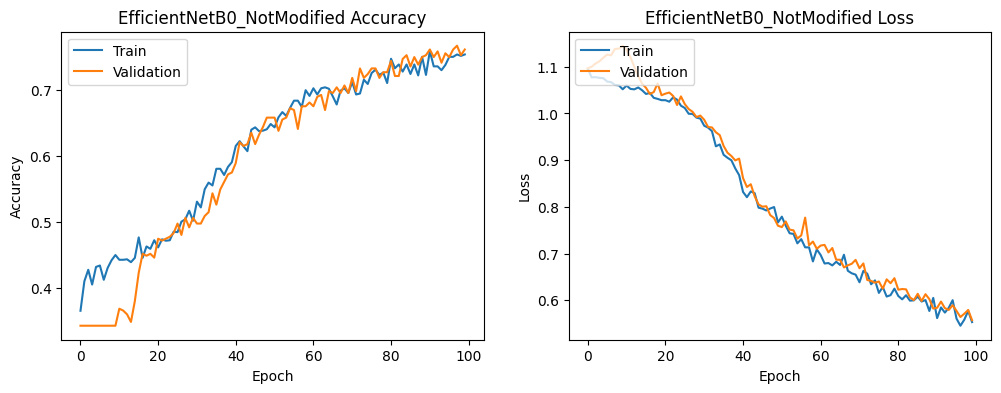

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.8287 - loss: 0.6700
Test Accuracy: 0.6549
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.77      0.87      0.82      1645
        rust       0.34      0.16      0.21       275
        scab       0.34      0.30      0.32       630

    accuracy                           0.65      2550
   macro avg       0.48      0.44      0.45      2550
weighted avg       0.62      0.65      0.63      2550



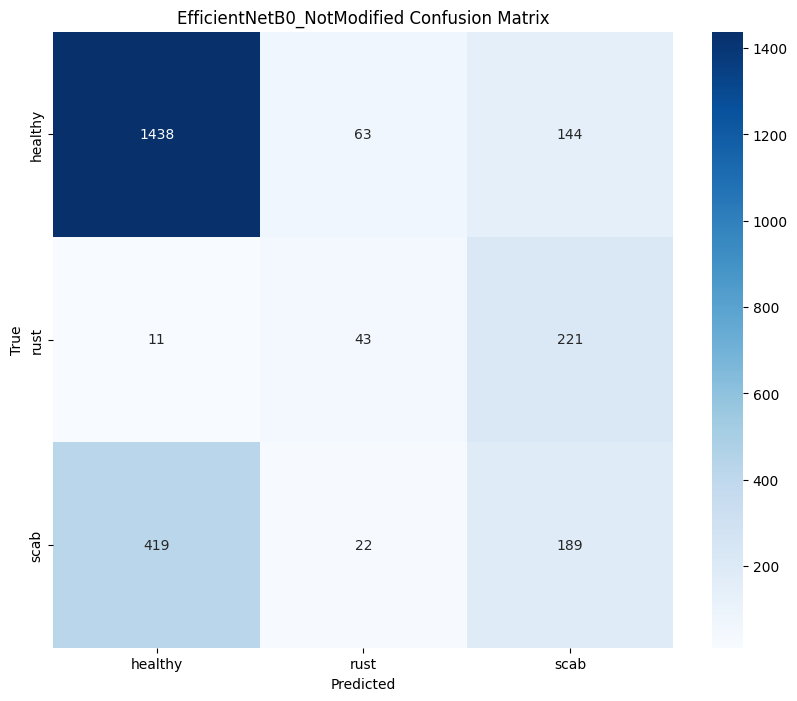

In [16]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(224, 224),
    batch_size=32,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 100
train_and_plot(model, "EfficientNetB0_NotModified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [7]:
model = EfficientNetB2(input_shape=(260, 260, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(260, 260, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1729658922.538884    6949 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729658922.539021    6949 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729658922.539071    6949 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729658923.092933    6949 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729658923.093112    6949 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/100


E0000 00:00:1729659194.722463    7033 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729659194.859150    7033 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-23 11:53:23.497346: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=2} for conv (f32[528,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,528,17,17]{3,2,1,0}, f32[8,528,17,17]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=528, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a whi

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.3865 - loss: 1.0880

E0000 00:00:1729659266.506627    7032 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729659266.642579    7032 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729659266.779486    7032 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729659266.913482    7032 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729659267.089201    7032 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

173/173 ━━━━━━━━━━━━━━━━━━━━ 85s 237ms/step - accuracy: 0.3866 - loss: 1.0880 - val_accuracy: 0.3420 - val_loss: 1.1161
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 0.4017 - loss: 1.0808 - val_accuracy: 0.3420 - val_loss: 1.1472
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 161ms/step - accuracy: 0.4253 - loss: 1.0684 - val_accuracy: 0.3621 - val_loss: 1.1147
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.3988 - loss: 1.0734 - val_accuracy: 0.4368 - val_loss: 1.0680
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.4126 - loss: 1.0650 - val_accuracy: 0.4655 - val_loss: 1.0523
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.4424 - loss: 1.0537 - val_accuracy: 0.4770 - val_loss: 1.0509
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.4489 - loss: 1.0605 - val_accuracy: 0.4741 - val_loss: 1.0697
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.4350 - loss: 1.053

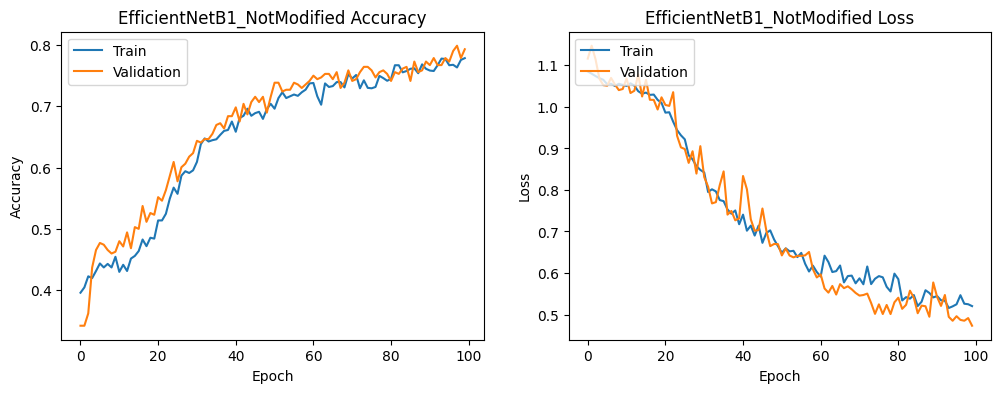

319/319 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8266 - loss: 0.6020
Test Accuracy: 0.6471
319/319 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.76      0.87      0.81      1645
        rust       0.91      0.12      0.21       275
        scab       0.31      0.31      0.31       630

    accuracy                           0.65      2550
   macro avg       0.66      0.43      0.44      2550
weighted avg       0.66      0.65      0.62      2550



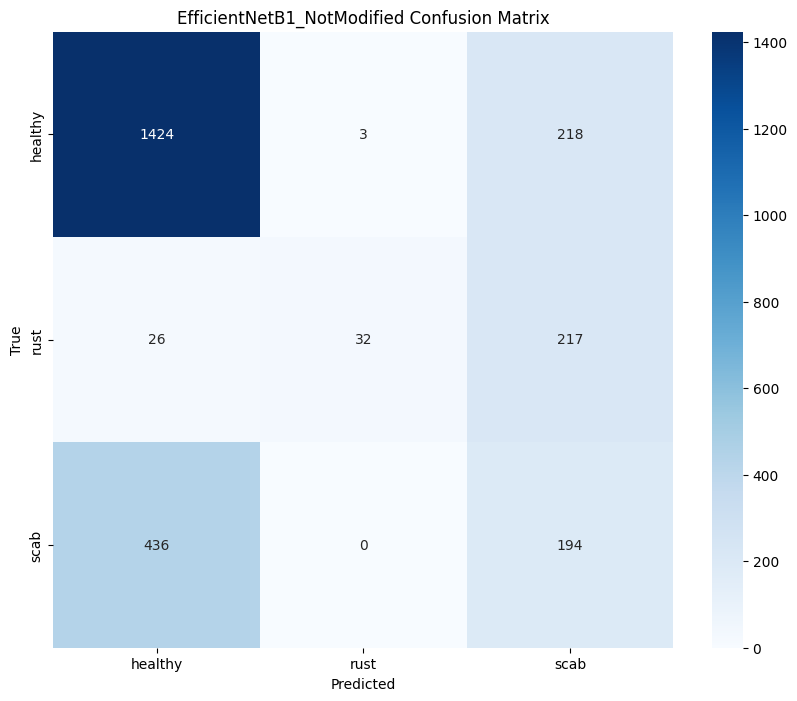

In [9]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(260, 260),
    batch_size=8,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 100
train_and_plot(model, "EfficientNetB1_NotModified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [7]:
model = EfficientNetB3(input_shape=(260, 260, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(260, 260, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1729662451.870955   11508 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729662451.871094   11508 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729662451.871146   11508 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729662452.754241   11508 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729662452.754362   11508 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


I0000 00:00:1729662481.571014   11594 service.cc:146] XLA service 0x7f7900002be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729662481.571095   11594 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-23 12:48:02.388507: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-23 12:48:05.612672: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1729662491.217154   11594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729662491.362160   11594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight System

108/173 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.3952 - loss: 1.0827

E0000 00:00:1729662552.392563   11594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729662552.539380   11594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-10-23 12:49:14.953576: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-23 12:49:15.065619: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more mem

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.3964 - loss: 1.0837

E0000 00:00:1729662610.802106   11596 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729662610.940417   11596 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


173/173 ━━━━━━━━━━━━━━━━━━━━ 160s 500ms/step - accuracy: 0.3963 - loss: 1.0837 - val_accuracy: 0.3420 - val_loss: 1.1119
Epoch 2/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.3789 - loss: 1.0902 - val_accuracy: 0.3420 - val_loss: 1.1099
Epoch 3/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.4072 - loss: 1.0767 - val_accuracy: 0.3506 - val_loss: 1.1352
Epoch 4/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 160ms/step - accuracy: 0.4014 - loss: 1.0721 - val_accuracy: 0.4052 - val_loss: 1.0663
Epoch 5/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.4337 - loss: 1.0627 - val_accuracy: 0.4109 - val_loss: 1.0962
Epoch 6/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.4675 - loss: 1.0454 - val_accuracy: 0.4282 - val_loss: 1.1483
Epoch 7/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 161ms/step - accuracy: 0.4384 - loss: 1.0500 - val_accuracy: 0.4310 - val_loss: 1.2718
Epoch 8/200
173/173 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.3995 - loss: 1.08

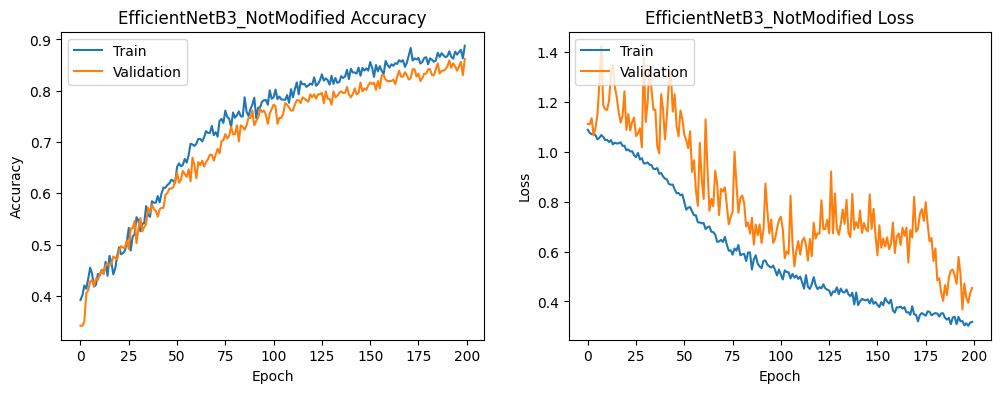

319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7072 - loss: 0.9269
Test Accuracy: 0.5671
319/319 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.73      0.74      0.73      1645
        rust       0.21      0.24      0.22       275
        scab       0.29      0.25      0.27       630

    accuracy                           0.57      2550
   macro avg       0.41      0.41      0.41      2550
weighted avg       0.56      0.57      0.56      2550



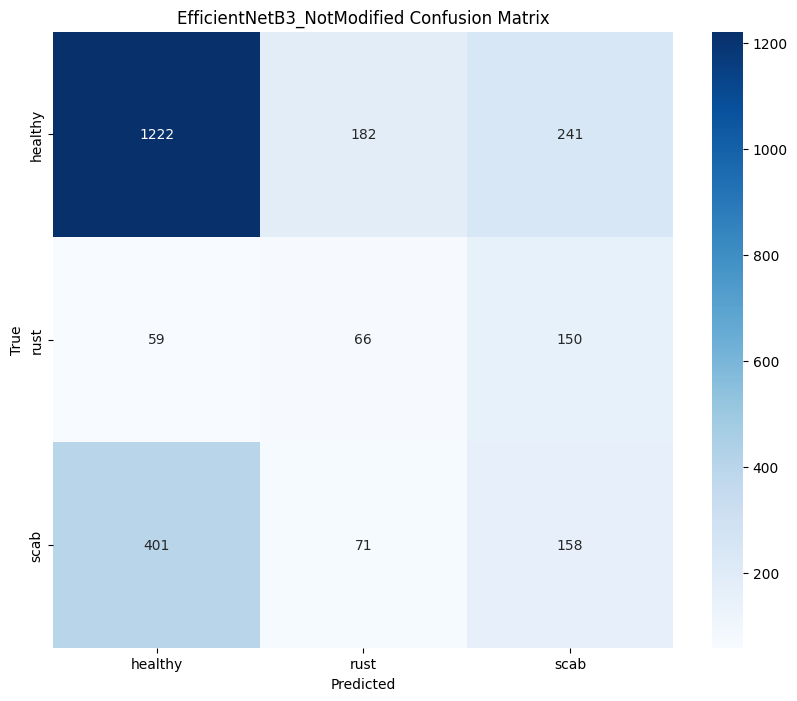

In [8]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(260, 260),
    batch_size=8,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 200
train_and_plot(model, "EfficientNetB3_NotModified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [7]:
model = EfficientNetB7(input_shape=(300, 300, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(300, 300, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1729675758.068755   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729675758.068886   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729675758.068931   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729675759.911081   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729675759.911216   23369 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    27,392,319 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,622,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,541,122 (116.51 MB)

 Trainable params: 30,413,051 (116.02 MB)

 Non-trainable params: 128,071 (500.28 KB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1729675816.936303   23452 service.cc:146] XLA service 0x7f9db40020a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729675816.936384   23452 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-10-23 16:30:18.716247: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-23 16:30:25.908496: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1729675841.255858   23452 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729675841.389734   23452 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight System

188/346 ━━━━━━━━━━━━━━━━━━━━ 28s 180ms/step - accuracy: 0.3931 - loss: 1.1030

E0000 00:00:1729675948.631973   23456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729675948.770451   23456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729675948.906702   23456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729675949.044441   23456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729675949.183319   23456 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

346/346 ━━━━━━━━━━━━━━━━━━━━ 279s 422ms/step - accuracy: 0.3971 - loss: 1.0992 - val_accuracy: 0.3420 - val_loss: 1.1344
Epoch 2/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 67s 194ms/step - accuracy: 0.3846 - loss: 1.0898 - val_accuracy: 0.3851 - val_loss: 1.8298
Epoch 3/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 195ms/step - accuracy: 0.4233 - loss: 1.0770 - val_accuracy: 0.4368 - val_loss: 3.9750
Epoch 4/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 196ms/step - accuracy: 0.4299 - loss: 1.0747 - val_accuracy: 0.3736 - val_loss: 3.3302
Epoch 5/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step - accuracy: 0.3808 - loss: 1.0962 - val_accuracy: 0.4023 - val_loss: 2.5894
Epoch 6/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 196ms/step - accuracy: 0.4307 - loss: 1.0695 - val_accuracy: 0.4195 - val_loss: 4.1685
Epoch 7/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 197ms/step - accuracy: 0.4002 - loss: 1.0825 - val_accuracy: 0.4454 - val_loss: 2.2188
Epoch 8/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 69s 199ms/step - accuracy: 0.3996 - loss: 1.06

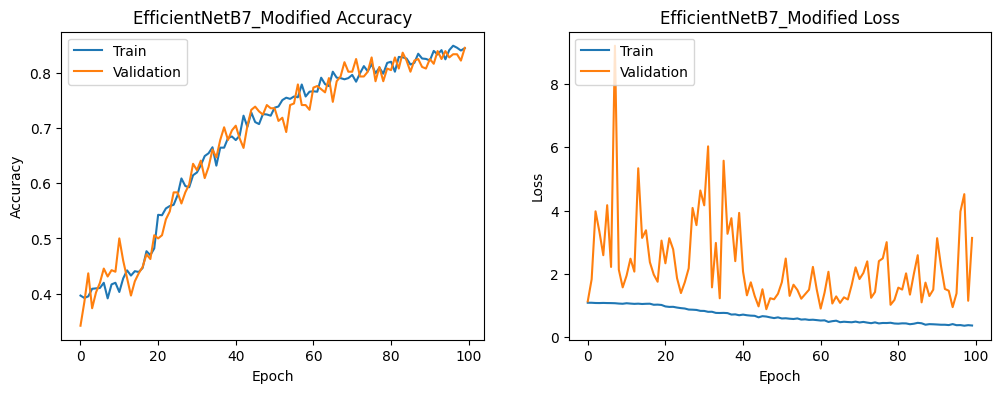

638/638 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.7539 - loss: 6.7549
Test Accuracy: 0.6039
638/638 ━━━━━━━━━━━━━━━━━━━━ 51s 64ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.75      0.80      0.77      1645
        rust       0.15      0.22      0.18       275
        scab       0.41      0.27      0.32       630

    accuracy                           0.60      2550
   macro avg       0.44      0.43      0.43      2550
weighted avg       0.60      0.60      0.60      2550



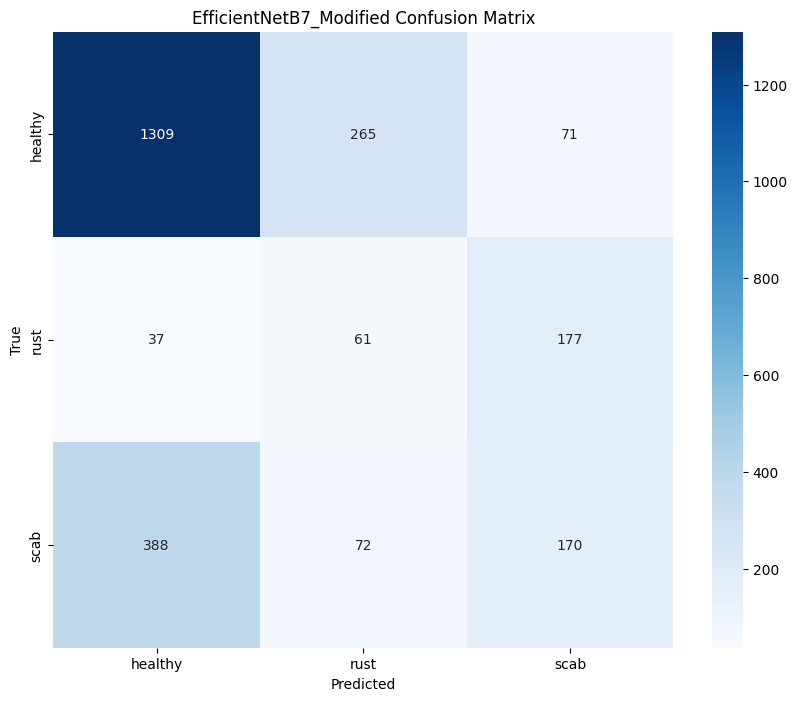

In [8]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(300, 300),
    batch_size=4,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 100
train_and_plot(model, "EfficientNetB7_Modified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [8]:
model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
model.trainable = True

inputs = Input(shape=(224, 224, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1729671865.254654   21093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729671865.254773   21093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729671865.254842   21093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729671866.588226   21093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729671866.588309   21093 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-23

ValueError: Layer count mismatch when loading weights from file. Model expected 75 layers, found 131 saved layers.

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.
Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 128s 759ms/step - accuracy: 0.3001 - loss: 1.7218 - val_accuracy: 0.3592 - val_loss: 1.1188
Epoch 2/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.4284 - loss: 1.3337 - val_accuracy: 0.4368 - val_loss: 1.0658
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.4505 - loss: 1.3179 - val_accuracy: 0.5431 - val_loss: 0.9671
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 285ms/step - accuracy: 0.5163 - loss: 1.1420 - val_accuracy: 0.6149 - val_loss: 0.8798
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 295ms/step - accuracy: 0.5487 - loss: 1.0815 - val_accuracy: 0.6408 - val_loss: 0.8048
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 276ms/step - accuracy: 0.5630 - loss: 0.9987 - val_accuracy: 0.6868 - val_loss: 0.7241
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 277ms/step - accuracy: 0.6312 - loss: 0.8638 - val_accurac

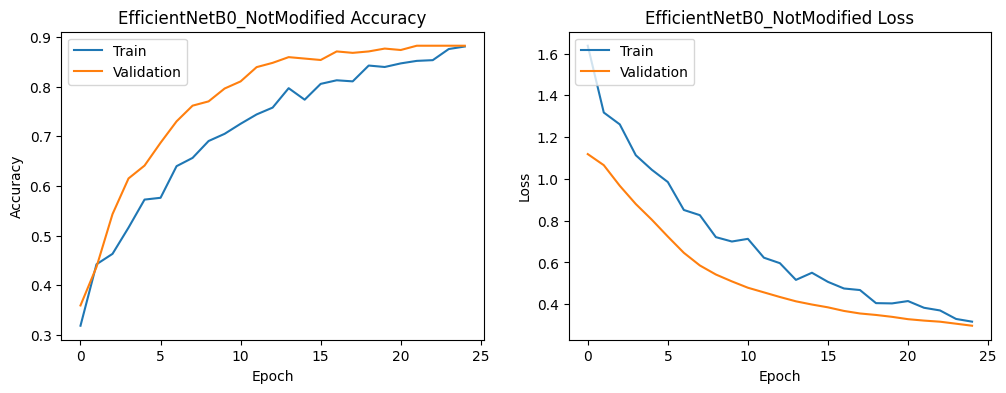

160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.5746 - loss: 1.0900
Test Accuracy: 0.5875
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.88      0.59      0.71      1645
        rust       0.85      0.11      0.19       275
        scab       0.35      0.80      0.49       630

    accuracy                           0.59      2550
   macro avg       0.70      0.50      0.46      2550
weighted avg       0.75      0.59      0.60      2550



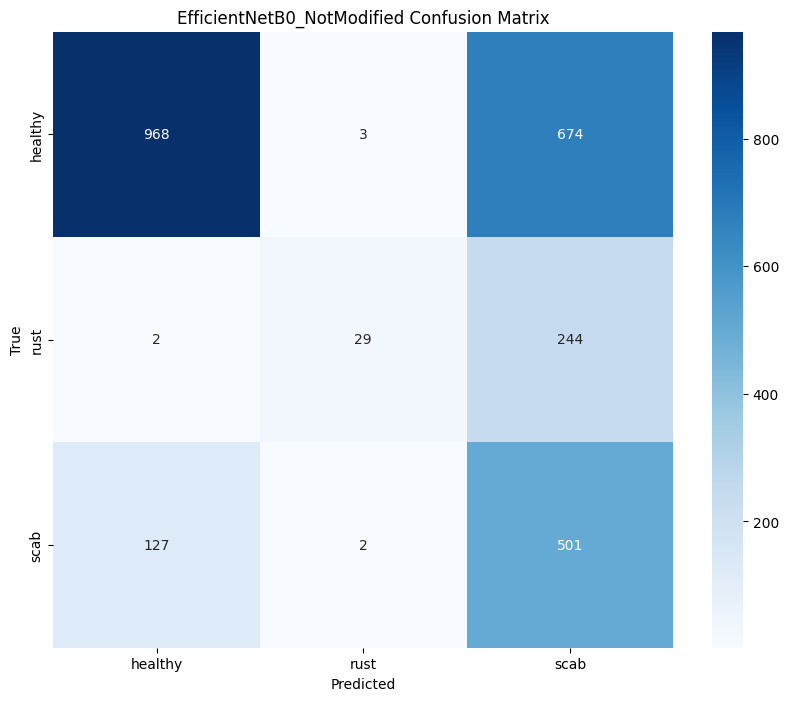

In [12]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(224, 224),
    batch_size=16,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 25
train_and_plot(model, "EfficientNetB0_NotModified", train_generator, validation_generator, test_generator, epochs =  epochs)

In [13]:
model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
model.trainable = True

# Freeze 50% layer pertama dari base model
total_layers = len(model.layers)
freeze_layers = int(0.50 * total_layers)
for layer in model.layers[:freeze_layers]:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/home/abiyamf/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 100s 641ms/step - accuracy: 0.3196 - loss: 1.6687 - val_accuracy: 0.4339 - val_loss: 1.0649
Epoch 2/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - accuracy: 0.4523 - loss: 1.3630 - val_accuracy: 0.4856 - val_loss: 0.9965
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 289ms/step - accuracy: 0.4826 - loss: 1.2405 - val_accuracy: 0.5661 - val_loss: 0.8999
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.5103 - loss: 1.1727 - val_accuracy: 0.6437 - val_loss: 0.8121
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.5638 - loss: 1.0652 - val_accuracy: 0.6753 - val_loss: 0.7508
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 275ms/step - accuracy: 0.5669 - loss: 1.0052 - val_accuracy: 0.7098 - val_loss: 0.6822
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - accuracy: 0.6660 - loss: 0.8715 - val_accuracy: 0.7385 - val_loss: 0.6211
Epoch 8/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step - accuracy: 0.6688 - loss: 0.8582 - val_acc

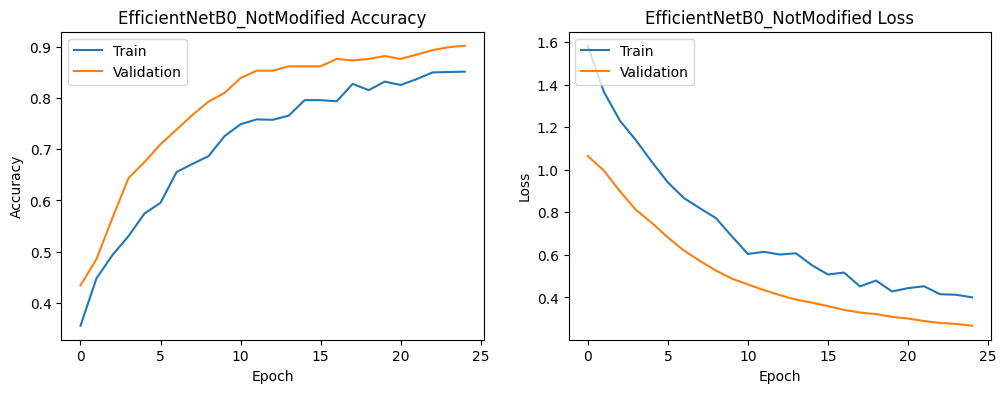

160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8957 - loss: 0.3315
Test Accuracy: 0.7635
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.84      0.93      0.88      1645
        rust       0.64      0.36      0.46       275
        scab       0.55      0.50      0.52       630

    accuracy                           0.76      2550
   macro avg       0.68      0.60      0.62      2550
weighted avg       0.75      0.76      0.75      2550



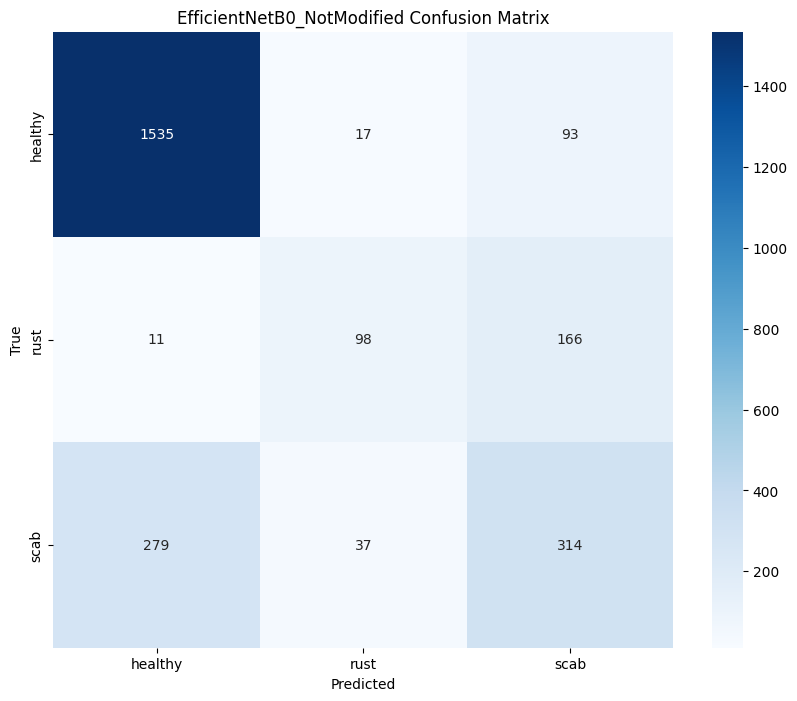

In [14]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(224, 224),
    batch_size=16,
    preprocess_input_func = efficientnet_preprocess
)
epochs = 25
train_and_plot(model, "EfficientNetB0_NotModified", train_generator, validation_generator, test_generator, epochs =  epochs)

### B7 RTX 4090

In [10]:
model = EfficientNetB7(input_shape=(600, 600, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(600, 600, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 600, 600, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    53,618,519 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,319,194 (207.21 MB)

 Trainable params: 54,062,483 (206.23 MB)

 Non-trainable params: 256,711 (1002.78 KB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.3037 - loss: 1.6199 - val_accuracy: 0.3420 - val_loss: 1.4662
Epoch 2/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 92s 528ms/step - accuracy: 0.3418 - loss: 1.4300 - val_accuracy: 0.3420 - val_loss: 1.6476
Epoch 3/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 152s 878ms/step - accuracy: 0.3572 - loss: 1.4127 - val_accuracy: 0.3420 - val_loss: 1.6766
Epoch 4/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 141s 814ms/step - accuracy: 0.3295 - loss: 1.5060 - val_accuracy: 0.3707 - val_loss: 2.8117
Epoch 5/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 90s 518ms/step - accuracy: 0.3423 - loss: 1.3977 - val_accuracy: 0.3678 - val_loss: 9.6644
Epoch 6/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 91s 524ms/step - accuracy: 0.3493 - loss: 1.3777 - val_accuracy: 0.3879 - val_loss: 16.2614
Epoch 7/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 94s 540ms/step - accuracy: 0.3736 - loss: 1.3454 - val_accuracy: 0.3736 - val_loss: 24.6332
Epoch 8/30
173/173 ━━━━━━━━━━━━━━━━━━━━ 90s 517ms/step - accuracy: 0.3793 - loss:

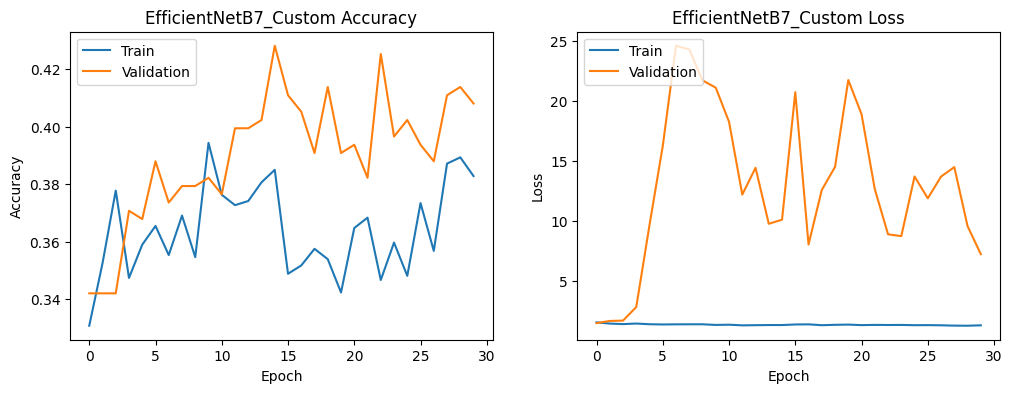

319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - accuracy: 0.1438 - loss: 29.4541
Test Accuracy: 0.2439
319/319 ━━━━━━━━━━━━━━━━━━━━ 50s 115ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.74      0.13      0.22      1645
        rust       0.00      0.00      0.00       275
        scab       0.24      0.66      0.35       630

    accuracy                           0.24      2550
   macro avg       0.33      0.26      0.19      2550
weighted avg       0.54      0.24      0.23      2550



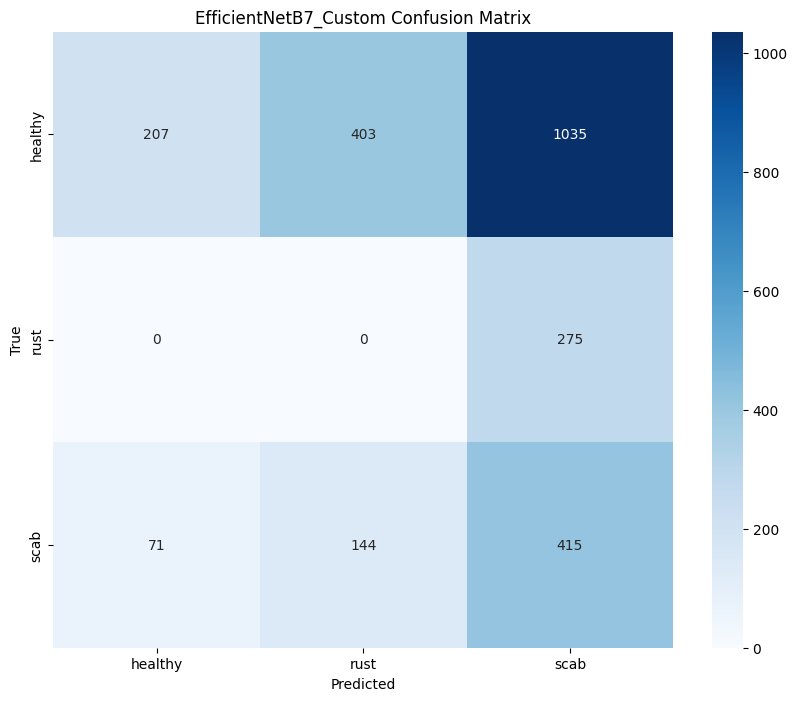

In [11]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(600, 600),
    batch_size=8,
    preprocess_input_func = efficientnet_preprocess
)

history_EN_B7, test_loss, test_acc, training_duration = train_and_plot(model, "EfficientNetB7_Custom", train_generator, validation_generator, test_generator, 30)

### B7 RTX A40

In [20]:
model = EfficientNetB7(input_shape=(600, 600, 3), include_top=False, weights=None)
model.trainable = True

inputs = Input(shape=(600, 600, 3))

x = model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 600, 600, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 19, 19, 2560)   │    57,222,263 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,922,938 (220.96 MB)

 Trainable params: 57,636,275 (219.86 MB)

 Non-trainable params: 286,663 (1.09 MB)

Found 1382 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 2550 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1729352052.189204    3395 service.cc:146] XLA service 0x71629c014390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729352052.189269    3395 service.cc:154]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2024-10-19 15:34:15.290693: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-19 15:34:24.340277: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8905
E0000 00:00:1729352088.393029    3395 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729352088.584163    3395 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1

135/173 ━━━━━━━━━━━━━━━━━━━━ 22s 584ms/step - accuracy: 0.3291 - loss: 1.4415

E0000 00:00:1729352341.561859    3393 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729352341.738734    3393 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729352342.603626    3393 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729352342.750182    3393 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1729352343.642149    3393 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

173/173 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - accuracy: 0.3310 - loss: 1.4393 - val_accuracy: 0.2989 - val_loss: 1.2354
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 111s 639ms/step - accuracy: 0.3477 - loss: 1.4143 - val_accuracy: 0.3420 - val_loss: 1.2928
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 98s 561ms/step - accuracy: 0.3676 - loss: 1.3640 - val_accuracy: 0.3448 - val_loss: 1.4572
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 104s 599ms/step - accuracy: 0.3927 - loss: 1.3141 - val_accuracy: 0.3994 - val_loss: 11.2917
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 91s 525ms/step - accuracy: 0.3979 - loss: 1.3161 - val_accuracy: 0.3966 - val_loss: 52.8341
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 89s 513ms/step - accuracy: 0.3597 - loss: 1.3155 - val_accuracy: 0.4052 - val_loss: 54.0727
Epoch 7/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 99s 568ms/step - accuracy: 0.3708 - loss: 1.3159 - val_accuracy: 0.3879 - val_loss: 60.1369
Epoch 8/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 96s 553ms/step - accuracy: 0.3663 - loss: 1.3408 -

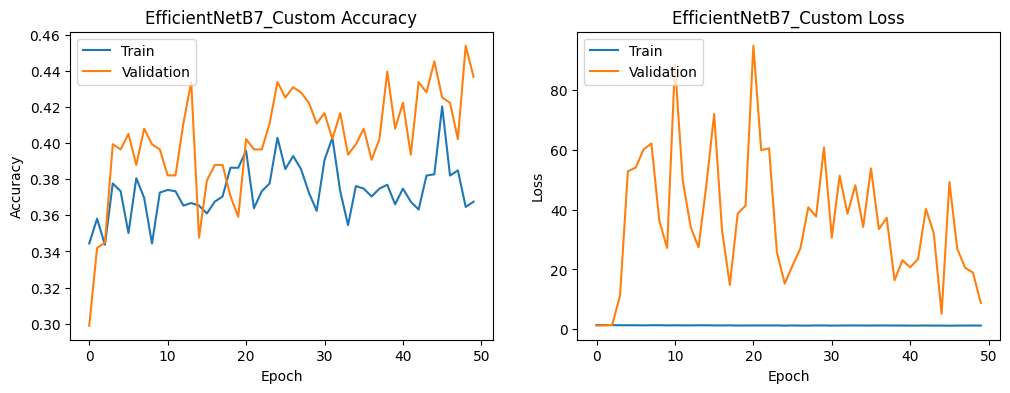

319/319 ━━━━━━━━━━━━━━━━━━━━ 51s 160ms/step - accuracy: 0.3766 - loss: 50.5613
Test Accuracy: 0.3792
319/319 ━━━━━━━━━━━━━━━━━━━━ 72s 168ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.77      0.40      0.53      1645
        rust       0.00      0.00      0.00       275
        scab       0.27      0.49      0.35       630

    accuracy                           0.38      2550
   macro avg       0.35      0.30      0.29      2550
weighted avg       0.56      0.38      0.43      2550



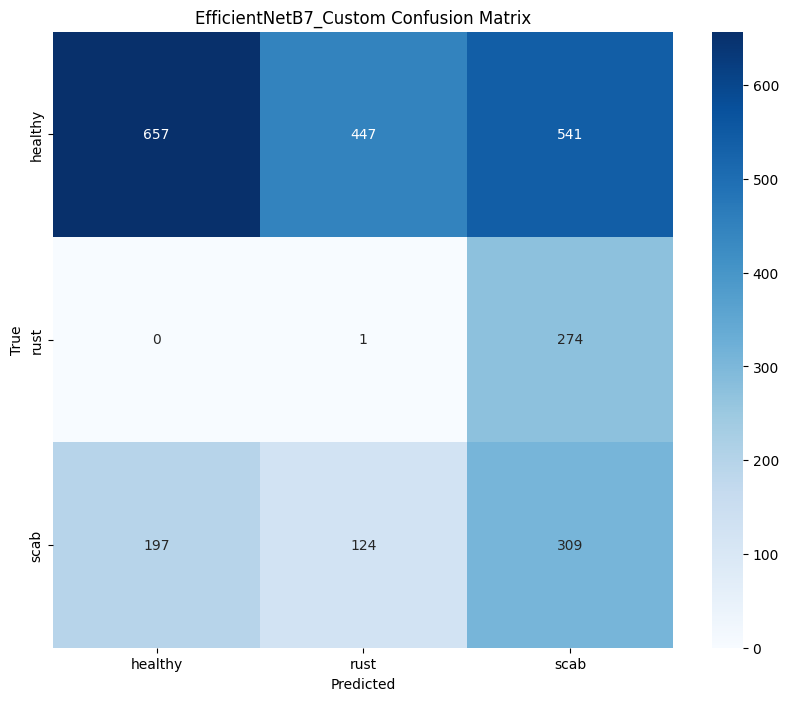

In [21]:
train_generator, validation_generator, test_generator = augment_and_resize_dataset(
    "data/split_train_test_dataset_campuran",
    img_size=(600, 600),
    batch_size=8,
    preprocess_input_func = efficientnet_preprocess
)

history_EN_B7, test_loss, test_acc, training_duration = train_and_plot(model, "EfficientNetB7_Custom", train_generator, validation_generator, test_generator, 50)

# Test KFold

In [ ]:
# train_generator, validation_generator, test_generator = augment_and_resize_dataset(
#     "data/split_train_test_dataset_campuran",
#     img_size=(600, 600),
#     batch_size=16,
#     preprocess_input_func = efficientnet_preprocess
# )

In [ ]:
# import numpy as np

# # Ekstrak seluruh data dan label dari generator
# def extract_images_labels(generator):
#     images = []
#     labels = []
#     for _ in range(len(generator)):  # Iterasi untuk setiap batch
#         img_batch, label_batch = next(generator)
#         images.append(img_batch)
#         labels.append(label_batch)
    
#     # Menggabungkan list menjadi array numpy
#     images = np.concatenate(images)
#     labels = np.concatenate(labels)
    
#     return images, labels

# # Ekstrak data dari train_generator
# train_images, train_labels = extract_images_labels(train_generator)


In [ ]:
# from sklearn.model_selection import KFold
# import numpy as np

# # Assuming you have train data and labels loaded, e.g., train_images, train_labels
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# fold_no = 1

# # Inisialisasi variabel untuk menyimpan hasil
# acc_per_fold = []
# loss_per_fold = []

# # K-Fold Cross Validation model evaluation
# for train_index, val_index in kfold.split(train_images, train_labels):
#     print(f'Training for fold {fold_no} ...')

#     # Split data into training and validation sets for the current fold
#     x_train_fold = train_images[train_index]
#     y_train_fold = train_labels[train_index]
#     x_val_fold = train_images[val_index]
#     y_val_fold = train_labels[val_index]

#     # Create model for this fold
#     model = EfficientNetB1(input_shape=(600, 600, 3), include_top=False, weights=None)
#     model.trainable = True
    
#     inputs = Input(shape=(600, 600, 3))
#     x = model(inputs, training=False)
#     x = GlobalAveragePooling2D()(x)
#     x = BatchNormalization()(x)
#     x = Dense(256, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.2)(x)
#     x = Dense(128, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.2)(x)
#     outputs = Dense(3, activation='softmax')(x)
#     model = Model(inputs, outputs)

#     # Compile the model
#     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#     # Train the model for this fold
#     history = model.fit(x_train_fold, y_train_fold,
#                         epochs=50,
#                         batch_size=16,
#                         validation_data=(x_val_fold, y_val_fold))

#     # Mengevaluasi model di data validasi
#     scores = model.evaluate(x_val_fold, y_val_fold, verbose=0)
#     print(f"Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%")
#     acc_per_fold.append(scores[1] * 100)
#     loss_per_fold.append(scores[0])

#     fold_no += 1

# # Menampilkan hasil akhir dari cross-validation
# print('Average scores for all folds:')
# print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
# print(f'> Loss: {np.mean(loss_per_fold)}')